# Lab14: NumPy + OpenCV

## Lab Goals

**Demo1**: Change crying emoji into smiley emoji

**Demo2**: Do histogram equalization on provided image

If you are not using docker containers or devcontainers
```bash
    pip install numpy opencv-python matplotlib  
```

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

## TA demo

real-time line detection

In [17]:
import cv2 as cv
import numpy as np
from IPython.display import display, clear_output
import time

def preprocess_frame(frame):
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    eroded = cv.erode(thresh, None, iterations=2)
    dilated = cv.dilate(eroded, None, iterations=2)
    edges = cv.Canny(dilated, 100, 200)
    return edges

def apply_roi_mask(edges, width, height):
    vertices = np.array([[
        (0, height), (width//20, 2*height//6),
        (19*width//20, 2*height//6), (width, height)
    ]], dtype=np.int32)

    mask = np.zeros_like(edges)
    cv.fillPoly(mask, vertices, 255)
    return cv.bitwise_and(edges, mask)

def classify_lines(lines, width):
    left_lines, right_lines = [], []
    middle_x = width / 2

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        slope = (y2-y1) / (x2 - x1)
        if 0.35 < slope < 0.85 and x1 > middle_x/2:
            right_lines.append(line)
        elif -0.85 < slope < -0.35 and x1 < 3*width/4:
            left_lines.append(line)
    return left_lines, right_lines

def calculate_triangle_area(vertices):
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]
    area = abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)) / 2.0
    return area

In [7]:
# cap = cv.VideoCapture(0)
cap = cv.VideoCapture('car.mp4')
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    overlay = frame.copy()
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)

    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)
    lines = cv.HoughLinesP(masked, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        left_lines, right_lines = classify_lines(lines, width)

        for line in left_lines:
            x1, y1, x2, y2 = line[0]
            cv.line(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for line in right_lines:
            x1, y1, x2, y2 = line[0]
            cv.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Triangle detection region: upper 2/3
    mask_tri = np.zeros_like(edges)
    roi_tri = np.array([[(0, 0), (width, 0), (width, 2*height//3), (0, 2*height//3)]], dtype=np.int32)
    cv.fillPoly(mask_tri, roi_tri, 255)
    edges_tri = cv.bitwise_and(edges, mask_tri)

    contours, _ = cv.findContours(edges_tri, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        if len(approx) == 3:
            area = calculate_triangle_area(approx[:, 0, :])
            if area > 15000:
                centroid = np.mean(approx, axis=0)
                distances = np.linalg.norm(approx[:, 0, :] - centroid, axis=1)
                tip = approx[np.argmax(distances)][0]
                if tip[0] > centroid[0][0]:
                    direction = 'Right'
                    color = (255, 255, 0)   # Blue for right
                else:
                    direction = 'Left'
                    color = (0, 0, 255)   # Red for left

                cv.drawContours(overlay, [approx], -1, color, 3)
                cv.putText(overlay, f"Triangle: {direction}", (20, 50),
                           cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                break  # Only detect one triangle
    
    # Display the frame using matplotlib
    clear_output(wait=True)
    plt.imshow(cv.cvtColor(overlay, cv.COLOR_BGR2RGB))
    plt.title("Frame")
    plt.axis('off')
    plt.show()

cap.release()

OpenCV: Couldn't read video stream from file "car.mp4"


# Demo1

### Step 0. Load Image

replace ```'your_image.jpg'``  with the path to the sad-man image

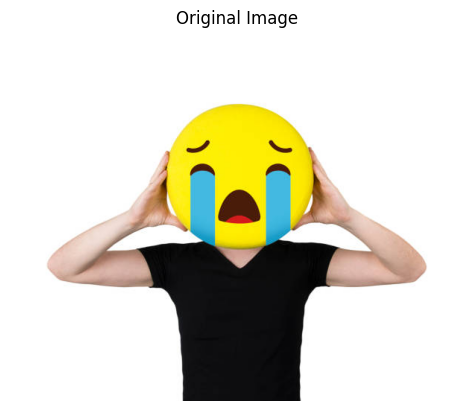

In [18]:
img = cv.imread('/Users/lucas/Documents/lab14/sad_man.jpg')
if img is None:
    raise ValueError("Image not found. Please check the path.")
show_img(img, "Original Image")

### Step 1. Color tracker - yellow

In [21]:
# 將影像從 BGR 轉換到 HSV 色彩空間
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# 定義黃色的 HSV 範圍
# 黃色在 HSV 中的色相範圍大約是 20-30
lower_yellow = np.array([20, 50, 50])
upper_yellow = np.array([30, 255, 255])

# 創建黃色的遮罩 (mask)
yellow_mask = cv.inRange(hsv, lower_yellow, upper_yellow)

# 可選：進行形態學操作來清理遮罩
kernel = np.ones((5,5), np.uint8)
yellow_mask = cv.morphologyEx(yellow_mask, cv.MORPH_CLOSE, kernel)
yellow_mask = cv.morphologyEx(yellow_mask, cv.MORPH_OPEN, kernel)

### your code below ### find contours for yellow region
contours, _ = cv.findContours(yellow_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
### your code above ###

img_contours = img.copy()
cv.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

# 假設您有 show_img 函數來顯示影像
# show_img(img_contours, "Color Contours: Yellow")

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

### Step 2. Bound the roi with a box

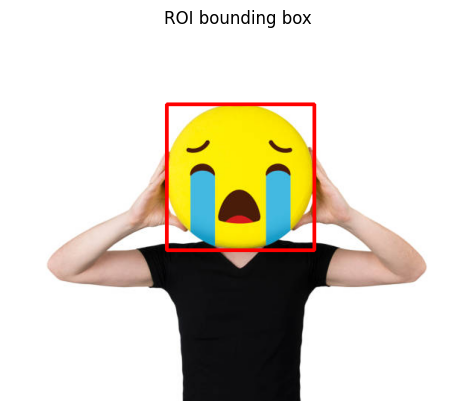

In [22]:
### your code below ###
img_blobs = img.copy()

# 方法1: 如果您有輪廓，為每個輪廓繪製邊界框
for contour in contours:
    # 獲取邊界矩形
    x, y, w, h = cv.boundingRect(contour)
    # 在影像上繪製矩形
    cv.rectangle(img_blobs, (x, y), (x + w, y + h), (255, 0, 0), 2)

# 方法2: 如果您要為所有輪廓繪製一個總邊界框
if len(contours) > 0:
    # 合併所有輪廓點
    all_points = np.vstack(contours)
    # 獲取總邊界矩形
    x, y, w, h = cv.boundingRect(all_points)
    # 繪製總邊界框（用不同顏色區分）
    cv.rectangle(img_blobs, (x, y), (x + w, y + h), (0, 0, 255), 3)

### your code above ###
show_img(img_blobs, f"ROI bounding box")

### Step 3. Replace crying face with smiley face

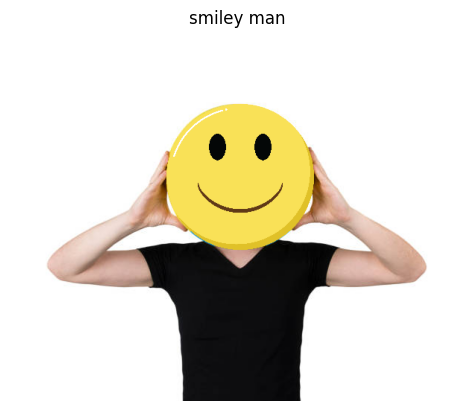

In [23]:
### your code below ### overlay the ROI with smiley face

# 載入笑臉圖片
smiley_img = cv.imread('/Users/lucas/Documents/lab14/smiley_emoji.png', cv.IMREAD_UNCHANGED)

if smiley_img is not None:
    for contour in contours:
        # 獲取每個輪廓的邊界框
        x, y, w, h = cv.boundingRect(contour)
        
        # 調整笑臉圖片大小以符合 ROI
        smiley_resized = cv.resize(smiley_img, (w, h))
        
        # 如果有透明通道，處理 alpha 混合
        if len(smiley_img.shape) == 3 and smiley_img.shape[2] == 4:
            # 處理透明度
            alpha = smiley_resized[:, :, 3] / 255.0
            alpha = np.expand_dims(alpha, axis=2)
            
            # Alpha 混合
            overlay = smiley_resized[:, :, :3]
            background = img[y:y+h, x:x+w]
            
            img[y:y+h, x:x+w] = (1 - alpha) * background + alpha * overlay
        else:
            # 直接覆蓋（如果沒有透明通道）
            img[y:y+h, x:x+w] = smiley_resized[:, :, :3]
else:
    print("警告：無法載入笑臉圖片，請檢查路徑是否正確")

### your code above ###
show_img(img, "smiley man")

# Demo2

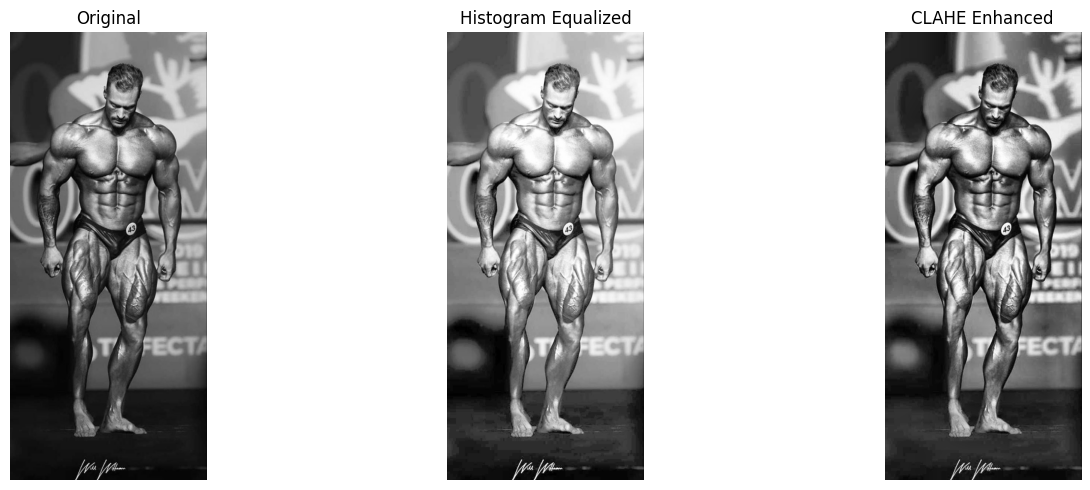

In [24]:
img = cv.imread("/Users/lucas/Documents/lab14/cbum.jpg")
### your code below ###
#### histogram equalized ####
# 將影像轉換為灰階
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# 對灰階影像進行直方圖等化
equalized = cv.equalizeHist(gray)

#############################
#### CLAHE processing ####
# 創建 CLAHE 對象
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# 對原始影像的各個通道分別進行 CLAHE 處理
enhanced = img.copy()
for i in range(3):  # 處理 BGR 三個通道
    enhanced[:,:,i] = clahe.apply(img[:,:,i])

##########################
### your code above ###

# Plot
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
eq_rgb = cv.cvtColor(equalized, cv.COLOR_GRAY2RGB)
clahe_rgb = cv.cvtColor(enhanced, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15, 5))
titles = ["Original", "Histogram Equalized", "CLAHE Enhanced"]
images = [img_rgb, eq_rgb, clahe_rgb]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()